In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import scipy.io
from IPython.display import Image, display

In [2]:
VGG_MODEL_PATH = './vgg19/imagenet-vgg-verydeep-19.mat'

class VGG19:
    def __init__(self, mat_path):
        vgg_rawnet = scipy.io.loadmat(mat_path)
        self.mean_pixel = np.array([123.68, 116.779, 103.939])
        self.layers = vgg_rawnet['layers'][0]
        self.layer_names = [l[0][0][0][0] for l in self.layers[:36]]

    # helper functions
    def _get_weights_bias(self, i):
        weights = self.layers[i][0][0][2][0][0]
        bias = self.layers[i][0][0][2][0][1]
        weights = np.transpose(weights, (1, 0, 2, 3))
        bias = bias.reshape(-1)
        return weights, bias

    def _conv_layer(self, current, weights, bias):
        conv = tf.nn.conv2d(current, weights, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.bias_add(conv, bias)

    def _pool_layer(self, current, use_average_pooling):
        args = {'value': current, 'ksize': [1, 2, 2, 1], 'strides': [1, 2, 2, 1], 'padding': 'SAME'}
        return tf.nn.avg_pool(**args) if use_average_pooling else tf.nn.max_pool(**args)

    def preprocess(self, image):
        return image - self.mean_pixel

    def undo_preprocess(self, image):
        return image + self.mean_pixel

    def feed_forward(self, input_image, scope=None, use_average_pooling=False):
        net = {}
        current = input_image
        
        with tf.variable_scope(scope):
            for i, name in enumerate(self.layer_names):
                ltype = name[:4]
                if ltype == 'conv':
                    weights, bias = self._get_weights_bias(i)
                    current = self._conv_layer(current, weights, bias)
                elif ltype == 'relu':
                    current = tf.nn.relu(current)
                elif ltype == 'pool':
                    current = self._pool_layer(current, use_average_pooling)
                net[name] = current
                
        assert len(net) == len(self.layer_names)
        return net

In [3]:
# helper functions
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    
    if max_size is not None:
        factor = max_size / np.max(image.size)
        size = np.array(image.size) * factor
        size = size.astype(int)
        
        image = image.resize(size, PIL.Image.LANCZOS)
    
    return np.float32(image)

def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0).astype(np.uint8)
    display(PIL.Image.fromarray(image))

def plot_images(content, style, mixed, smooth=True):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    interpolation = 'sinc' if smooth else 'nearest'
    
    images = [content, style, mixed]
    for ax, img in zip(axes.flat, images):
        ax.imshow(img / 255.0, interpolation=interpolation)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

def add_one_dim(image):
    shape = (1,) + image.shape
    return np.reshape(image, shape)

def gram_matrix(tensor):
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix =  tf.reshape(tensor, shape=[-1, num_channels])
    return tf.matmul(tf.transpose(matrix), matrix)

def create_denoise_loss(image):
    return tf.reduce_sum(tf.abs(image[:,1:,:,:] - image[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(image[:,:,1:,:] - image[:,:,:-1,:]))

In [4]:
content_file = './images/me.jpg'
style_file = './images/Matisse-the-Dance.jpg'

content_image = load_image(content_file)
style_image = load_image(style_file)

content_layers = ['conv4_2', 'conv5_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1',
                'relu1_2', 'relu2_2', 'relu3_2', 'relu4_2', 'relu5_2']

content_layer_weights = [0.5, 0.5]
style_layer_weights = np.repeat(1.0 / len(style_layers), len(style_layers)).tolist()

loss_ratio = 5e-2 # weight of content-loss relative to style loss
denoise_ratio = 0.25
learning_rate = 2
num_iter = 500
use_average_pooling = False

In [5]:
CONTENT_LAYERS = {l: w for l, w in zip(content_layers, content_layer_weights)}
STYLE_LAYERS = {l: w for l, w in zip(style_layers, style_layer_weights)}

content_image1 = add_one_dim(content_image)
style_image1 = add_one_dim(style_image)
init_image = content_image1 # could be random though

sess = tf.Session()

In [6]:
%%time
net = VGG19(VGG_MODEL_PATH)

CPU times: user 3.64 s, sys: 140 ms, total: 3.78 s
Wall time: 3.74 s


In [7]:
p0 = np.float32(net.preprocess(content_image1))
a0 = np.float32(net.preprocess(style_image1))
x0 = np.float32(net.preprocess(init_image))

# build the graph

# this is what must be trained
x = tf.Variable(x0, trainable=True, dtype=tf.float32)

# graph input
p = tf.placeholder(tf.float32, shape=p0.shape, name='content')
a = tf.placeholder(tf.float32, shape=a0.shape, name='style')

In [8]:
# get content-layer features
content_layers = net.feed_forward(p, scope='content', use_average_pooling=use_average_pooling)
Ps = {i: content_layers[i] for i in CONTENT_LAYERS}

# get style-layer features
style_layers = net.feed_forward(a, scope='style', use_average_pooling=use_average_pooling)
As = {i: gram_matrix(style_layers[i]) for i in STYLE_LAYERS}

# get layer features for x
Fs = net.feed_forward(x, scope='mixed', use_average_pooling=use_average_pooling)

In [9]:
# compute loss
loss_content = 0
loss_style = 0

for i in Fs:
    if i in CONTENT_LAYERS:
        # content loss
        F, P = Fs[i], Ps[i]        # content features of x and p

        _, h, w, d = F.get_shape() # 
        N = h.value * w.value      # product of width and height
        M = d.value                # number of filters
        weight = CONTENT_LAYERS[i] # weight for this layer

        # TODO: try different formulas for losses
#         loss_content += weight * tf.reduce_sum(tf.square(F - P)) / 2
        loss_content += weight * (1. / (2. * np.sqrt(N) * np.sqrt(M))) * tf.reduce_sum(tf.square(F - P))
    elif i in STYLE_LAYERS:
        # style loss
        F = Fs[i]                    # features of x
        G, A = gram_matrix(F), As[i] # style features of x and a

        _, h, w, d = F.get_shape()   # 
        N = h.value * w.value        # product of width and height
        M = d.value                  # number of filters
        weight = STYLE_LAYERS[i]     # weight for this layer
        
        loss_style += weight * (1. / (4. * N ** 2 * M ** 2)) * tf.reduce_sum(tf.square(G - A))

alpha = loss_ratio
beta = 1 - alpha

denoise_loss = create_denoise_loss(x)

loss_total = alpha * loss_content + beta * loss_style + denoise_ratio * denoise_loss

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss_total)

sess.run(tf.global_variables_initializer())

run_list = [train, loss_total, loss_content, loss_style, denoise_loss]

In [11]:
%%time
history = []
for i in range(num_iter):
    _, lt, lc, ls, dl = sess.run(run_list, feed_dict={a: a0, p: p0})
    history.append(lt)
    
    if (i % 50 == 0) or (i == num_iter - 1):
        print('i: {0}, lt: {1:.2e}, lc: {2:.2e}, ls: {3:.3e}, dl: {4:.3e}'.format(i, lt, lc, ls, dl))
#         mixed_image = np.clip(net.undo_preprocess(sess.run(x)[0]), 0.0, 255.0)
#         plot_images(content_image, style_image, mixed_image)

i: 0, lt: 5.89e+09, lc: 5.53e-05, ls: 6.200e+09, dl: 8.877e+06
i: 50, lt: 2.32e+08, lc: 5.34e+08, ls: 2.116e+08, dl: 1.516e+07
i: 100, lt: 1.38e+08, lc: 5.71e+08, ls: 1.117e+08, dl: 1.470e+07
i: 150, lt: 1.11e+08, lc: 5.85e+08, ls: 8.186e+07, dl: 1.451e+07
i: 200, lt: 9.54e+07, lc: 5.90e+08, ls: 6.563e+07, dl: 1.435e+07
i: 250, lt: 8.51e+07, lc: 5.91e+08, ls: 5.476e+07, dl: 1.421e+07
i: 300, lt: 7.77e+07, lc: 5.91e+08, ls: 4.696e+07, dl: 1.408e+07
i: 350, lt: 7.19e+07, lc: 5.89e+08, ls: 4.101e+07, dl: 1.394e+07
i: 400, lt: 6.73e+07, lc: 5.87e+08, ls: 3.627e+07, dl: 1.378e+07
i: 450, lt: 6.35e+07, lc: 5.86e+08, ls: 3.237e+07, dl: 1.364e+07
i: 499, lt: 6.10e+07, lc: 5.83e+08, ls: 2.999e+07, dl: 1.344e+07
CPU times: user 1min 21s, sys: 1min 22s, total: 2min 43s
Wall time: 2min 28s


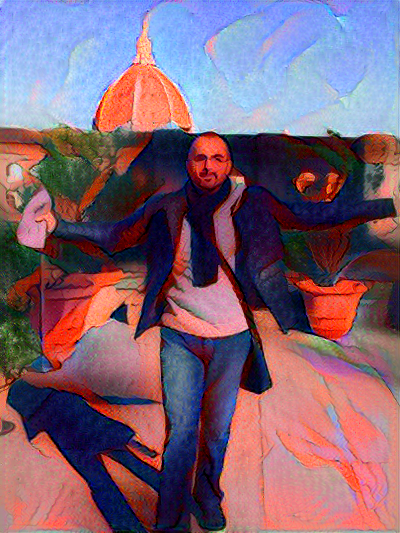

In [12]:
img = np.clip(net.undo_preprocess(sess.run(x)[0]), 0.0, 255.0)
plot_image_big(img)

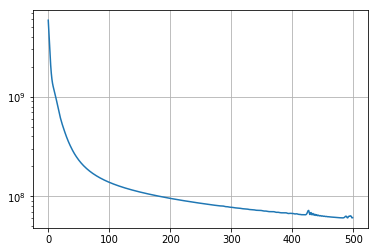

In [13]:
plt.plot(history)
plt.yscale('log')
plt.grid()

In [14]:
sess.close()
del net